In [20]:
import os
from srs.utilities import Sentence
from srs.maxEntropyModel import load_labelled_sent, loadWordListDict, train, cond_prob, loadUsefulTrainingData
from srs.predictor import StaticPredictor
import matplotlib.pyplot as plt
import numpy as np
import json
%matplotlib inline 

## Loading training sentences

In [2]:
static_traning_data_dir = os.path.abspath('../srs/static_training_data/')

sentences = loadUsefulTrainingData(static_traning_data_dir)

## Statistical analysis on training data

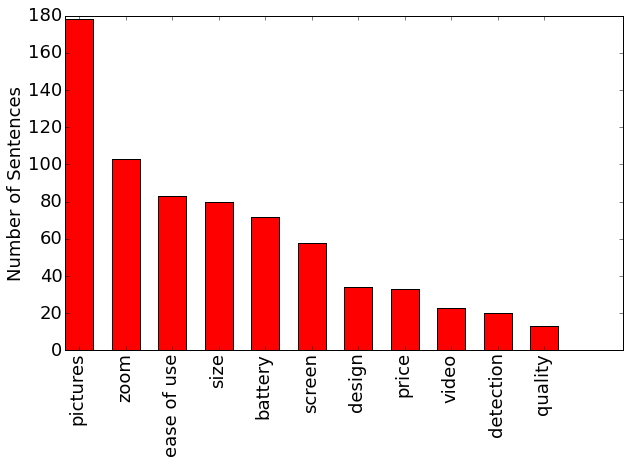

In [3]:
# static aspect counting
static_label_dict = {}
for sentence in sentences:
    if sentence.labeled_aspects not in static_label_dict:
        static_label_dict[sentence.labeled_aspects] = 1
    else:
        static_label_dict[sentence.labeled_aspects] += 1

#sorting
static_label_tups_sorted = sorted(static_label_dict.items(), key=lambda tup: -tup[1])
static_label_sorted = [tup[0] for tup in static_label_tups_sorted]
static_count_sorted = [tup[1] for tup in static_label_tups_sorted]

ind = np.arange(len(static_label_sorted))
width = 0.6
heights = static_count_sorted

plt.figure(figsize=[10,6])
ax = plt.gca()
ax.bar(ind, heights, width, color='r')
ax.set_xticks(ind+width/2)
ticks = ax.set_xticklabels(static_label_sorted, rotation=90)
plt.ylabel(u'Number of Sentences')

# set plotting params
plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['xtick.labelsize'] = plt.rcParams['font.size']
plt.rcParams['ytick.labelsize'] = plt.rcParams['font.size']
    

## Predicting

In [11]:
# set up predictor
staticPredictor = StaticPredictor()
params_file = '../srs/predictor_data/lambda_opt_1.txt'
static_aspect_list_file = '../srs/predictor_data/static_aspect_list.txt'
staticPredictor.loadParams(params_file)
staticPredictor.loadStaticAspectList(static_aspect_list_file)

staticPredictor.wordlist_dict = loadWordListDict('../srs/predictor_data/wordlist_dict_1.txt')

wordlist_dict has 11 keys.


In [12]:
validation_set = sentences[:]
correct = 0.0
correct_dict = {}
incorrect_dict = {}
expect_dict = {}
for sentence in validation_set:
    predicted_aspect = staticPredictor.predict(sentence, cp_threshold=0)
    if predicted_aspect == sentence.labeled_aspects:
        correct += 1
        if predicted_aspect not in correct_dict:
            correct_dict[predicted_aspect] = [sentence]
        else:
            correct_dict[predicted_aspect].append(sentence)
    else:
        if predicted_aspect not in incorrect_dict:
            incorrect_dict[predicted_aspect] = [sentence]
        else:
            incorrect_dict[predicted_aspect].append(sentence)
        
        if sentence.labeled_aspects not in expect_dict:
            expect_dict[sentence.labeled_aspects] = [sentence]
        else:
            expect_dict[sentence.labeled_aspects].append(sentence)
        

In [17]:
accuracy = correct/len(sentences)
print accuracy

0.619799139168


In [13]:
print "Precision:"
print '-----------'
for aspect in correct_dict:
    print aspect
    if aspect in incorrect_dict:
        print len(correct_dict[aspect])*1.0/(len(correct_dict[aspect]) + len(incorrect_dict[aspect]))
    else:
        print 1.0

Precision:
-----------
battery
0.455172413793
pictures
0.577405857741
screen
0.704918032787
zoom
0.733333333333
ease of use
0.7
detection
0.625
video
0.777777777778
design
0.652173913043
price
0.789473684211
size
0.793103448276


In [14]:
print "Recall:"
print "----------"
for aspect in correct_dict:
    print aspect
    print len(correct_dict[aspect])*1.0/(len(correct_dict[aspect]) + len(expect_dict[aspect]))

Recall:
----------
battery
0.916666666667
pictures
0.775280898876
screen
0.741379310345
zoom
0.533980582524
ease of use
0.506024096386
detection
0.25
video
0.304347826087
design
0.441176470588
price
0.454545454545
size
0.575


In [1]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')
word_list = ['cheaper', 'expensive', 'affordable', 'color', 
             'pretty', 'auto', 'modes', 'smart', 'focus','carry',
            'smaller', 'pocketable', 'bulky', 'photo', 'photos']
for i in range(len(word_list)):
    word = word_list[i]
    stemmedWord = stemmer.stem(word)
    print stemmedWord

cheaper
expens
afford
color
pretti
auto
mode
smart
focus
carri
smaller
pocket
bulki
photo
photo


In [19]:
aspect = "battery"
print len(correct_dict[aspect]) + len(incorrect_dict[aspect])
for sent in incorrect_dict[aspect]:
    print sent.content

145
For the digital novice, this versatility is perhaps an initial disadvantage since it'll take effort and time to become knowledgeable and well-practiced in all of them.

Indeed, the 181-page user guide is a prodigious read.

If you research this camera you will find no strong argument that any camera in its class exceeds the S-45 in quality/features.

On the plus side, the S45 has:1) 9 point AutoFocus

6) close to centered tripod attachment for easier stitch photo taking

On the minus side:1) Decent to weak flash that is better than the S400 but still weak for low light and night photos at greater than 10 feet away.

The control is ok but not as good as traditional SLR cameras or S400.2.

There is some noise at low light levels, but this is true of all CCD cameras, and the S45 is about average in this respect.

It's user interface is an atrocity, buttons have icons rather than labels, there is no menu tab, etc.

It's smaller than most cameras with the same amount of megapixels, but 

## Practical scheme summary

In prediction phase, if `max(cp)` is higher than 50%, we choose the static aspect corresponding to `max(cp)`, OTHERWISE, we choose `no feature`, which means we will discard this sentence when doing sentiment analysis.